# ELG7186 - fall 2022 - Assignment 1
## Due: <strong>Wednesday Oct. 12<sup>th</sup> 2022 -- 11:59pm</strong>

The purpose of this assignment is to gain some experience working with the tools you will use throughout the course. You will learn:
- The basics of data loading and preparation
- Classification using the k-NN algorithm
- Classification using a Support Vector Machine (SVM)
- Calculation of metrics to assess the performance of your model

### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you will submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


## Part 0. Dataset Preparation
To complete the assignment you will need to download the Cifar10 dataset and devise an appropriate training set split. You may acquire the dataset using the method of your choice. Note that some sources e.g. sklearn have reduced the samples to only 1797 (this could negatively affect your results). If you use the full dataset, you are free to sample from the dataset to reduce the overal training samples. The overall accuracy is less important than your  observations and comparisons. For example classifying the full 10,000 test images might take approximately 15 minutes using k-NN.

In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Divide the raw data into appropriate training and test sets for both the images and corresponding labels for use with the subsequent parts of the assignment.</li>
<li>Visualize five samples of each class by plotting a grid using the matplotlib library.</li>
</ul>


The libraries used 

In [1]:
import numpy as np
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical   
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from matplotlib.colors import Normalize
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# **Prepare The dataset** 

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [3]:
print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


## **Class Distribution**

Text(0.5, 1.0, 'Class distribution in training set')

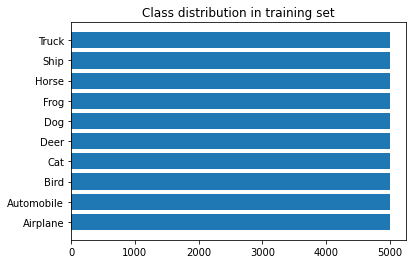

In [ ]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
classes, count = np.unique(y_train, return_counts=True)
plt.barh(classes_name, count)
plt.title('Class distribution training set')

Text(0.5, 1.0, 'Class distribution in testing set')

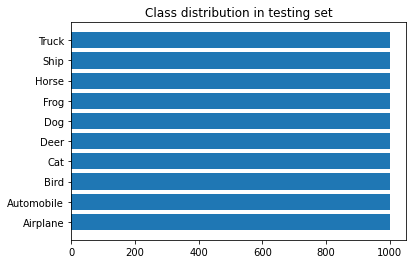

In [ ]:
classes, count = np.unique(y_test, return_counts=True)
plt.barh(classes_name, count)
plt.title('Class distribution testing set')

##**The five sample for the 10 classes**

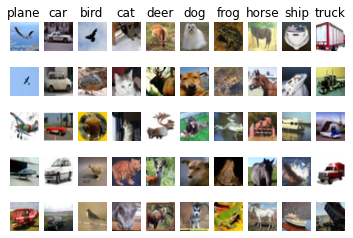

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Part 1. k-NN Classifier (2 Marks)
For this section you will implement a simple kNN Classifier on the Cifar10 dataset. To do this you will need to perform the following steps:
- Create a k-NN class. Your class must contain a method that returns predictions for your test set.
- Provide a suitable distance metric that you will use to calculate the nearest neightbours. You may choose the distance metric you believe is most suitable.
- Calculate the k nearest neighbours and make predictions.
- Choose the a value for _k_ that results in the highest accuracy on your test set. Show how you found this value.

When your classifier is working:
- Use sklearn to calculate accuracy and plot a confusion matrix using your predictions.
- Provide a brief discussion of your results

### Bonus:

When you compute the distance metric you can acheive better performance if you vectorize the computation instead of using for loops to iterate through the values. You can earn __0.5 bonus marks__ if you only need one loop, or __1 bonus mark__ if you can omit for loops for a fully vectorized distance calculation (a maximum of 1 bonus mark is available).




In [ ]:
# Write your KNN class here

##**function KNN from scratch**

In [ ]:
class kNN():
    '''k-Nearest Neighbours'''
    # Initialise
    def __init__(self, k=11, metric='euclidean', p=None):
        self.k = k
        self.metric = metric
        self.p = p
    
    # Euclidean distance (l2 norm)
    def euclidean(self, v1, v2):
        return np.sqrt(np.sum((v1-v2)**2))
    
    # Manhattan distance (l1 norm)
    def manhattan(self, v1, v2):
        return np.sum(np.abs(v1-v2))
    
    # Minkowski distance (lp norm)
    def minkowski(self, v1, v2, p=2):
        return np.sum(np.abs(v1-v2)*2)*(1/2)
        
    # Store train set
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
        # Make predictions
    def predict(self, X_test):
        preds = []
        # Loop over rows in test set
        for test_row in X_test:
            nearest_neighbours = self.get_neighbours(test_row)
            majority = stats.mode(nearest_neighbours)[0][0]
            preds.append(majority)
        return np.array(preds)
    
    # Get nearest neighbours
    def get_neighbours(self, test_row):
        distances = list()
        
        # Calculate distance to all points in X_train
        for (train_row, train_class) in zip(self.X_train, self.y_train):
            if self.metric=='euclidean':
                dist = self.euclidean(train_row, test_row)
            elif self.metric=='manhattan':
                dist = self.manhattan(train_row, test_row)
            elif self.metric=='minkowski':
                dist = self.minkowski(train_row, test_row, self.p)
            else:
                raise NameError('Supported metrics are euclidean, manhattan and minkowski')
            distances.append((dist, train_class))
            
        # Sort distances
        distances.sort(key=lambda x: x[0])
        
        # Identify k nearest neighbours
        neighbours = list()
        for i in range(self.k):
            neighbours.append(distances[i][1])
            
        return neighbours

In [ ]:
def accuracy(preds, y_test):
    return 100 * (preds == y_test).mean()

##**Reshape the images**

In [4]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(50000, 3072) (10000, 3072)


##**Take samples from data "30000 training with 10000 Testing"**

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 30000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
num_test = 10000
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

##use three metric to see the accuracy

In [ ]:
# Function to calculate accuracy

for metric in ['euclidean', 'manhattan','minkowski']:
    clf = kNN(k=43, metric=metric)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print(f'Metric: {metric}, accuracy: {accuracy(preds, y_test):.3f} %')

Metric: euclidean, accuracy: 21.120 %
Metric: manhattan, accuracy: 22.470 %
Metric: minkowski, accuracy: 19.860 %


##Use KNN with some odd numbers and with eclidean metric

Text(0, 0.5, 'Accuracy')

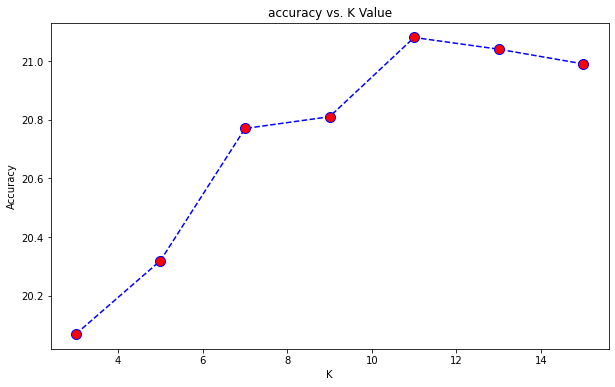

In [ ]:
acc_KNN = []
ran=[3,5,7,9,11,13,15]
for i in ran:
    knn = kNN(k=i,metric='euclidean')
    knn.fit(X_train,y_train)
    y_predictKNN = knn.predict(X_test)
    acc_KNN.append(accuracy(y_test, y_predictKNN))
    
plt.figure(figsize=(10,6))
plt.plot(ran,acc_KNN,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')


In [ ]:
acc_KNN

[20.07, 20.32, 20.77, 20.810000000000002, 21.08, 21.04, 20.990000000000002]

In [ ]:
knn = kNN(k=11,metric='euclidean')
knn.fit(X_train,y_train)
y_predictKNN = knn.predict(X_test)
print(accuracy_score(y_test, y_predictKNN))    

0.2108


In [ ]:
#Generate the confusion matrix
cf_matrix_KNN = confusion_matrix(y_test, y_predictKNN)
print(cf_matrix_KNN)

[[704  18  89  12   8   5  10   4 144   6]
 [439 183 109  32  25  12  17  15 141  27]
 [462  17 331  38  45  20  19  10  57   1]
 [389  34 228 114  48  37  37  21  81  11]
 [450  16 272  21 100  22  22  22  72   3]
 [416  30 229  76  33  69  39  21  74  13]
 [355  25 316  55  77  26  84  11  44   7]
 [462  40 188  34  51  10  21  71 107  16]
 [476  31  71  15   7   6   9   4 371  10]
 [468 133  66  21  18  13  14   6 180  81]]


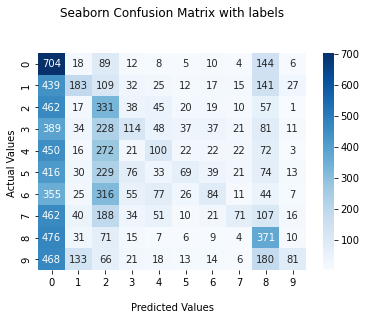

In [ ]:
ax = sns.heatmap(cf_matrix_KNN, annot=True, cmap='Blues',fmt='d')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

##**discussion of KNN results**

##### Using knn with images, we discovered that the accuracy of the data is determined by its quality. With a large amount of data, the fitting and  prediction stage may take a long time, be sensitive to the size of the data, and be sensitive to features that aren't significant. first, I choose euclidian metric because it helps to have more than one class with good performance, when I used manhattan, it was a good performance in one class. second, when K=11 was the best performance of any other class. it gives an accuracy equal 21.08% .
#####The model accurately assigned an image to its currently prevalent is the true positive prediction. For example, out of the 4621 images in our testing set with class 0 , the model detects 704 of them as correct classifications and 3917 as incorrect classifications.

## Part 2. Logistic Regression (3 Marks)

For this section you will perform binary classification using logistic regression. Just as in Part 1. you will use the Cifar10 dataset, however to obtain a result for each class using logistic regression you will need to use a One-vs-Rest (OvR) approach to acheive multi-class classification.

Using ```LogisticRegression()``` in sklearn, write a function to execute the OvR strategy for the Cifar10 classes. Do not use the built-in ```OneVsResClassifier()``` method. You will need to follow these basic steps:
- Train a binary classifier for each class, where the target class is a "positive" results and the combination of the remaining classes are "negative". For Cifar10 you will need 10 models.
- For each test sample compute the probabilities for each model
- Select the argmax of the probabilities to obtain the predicted class

Collect your predictions from the test set and compute the accuracy score and plot a confusion matrix.

In [ ]:
# Write your logistic regression code here.

#**Logistic Regression**

## with OVR using sklearn

In [ ]:
model = LogisticRegression()
ovr = OneVsRestClassifier(model)
ovr.fit(X_train, y_train)
y_predictLR = ovr.predict(X_test)

In [ ]:
acc_ovrLR = accuracy_score(y_test, y_predictLR)

##Create function for OVR with binarize labels

In [ ]:
def OVR_func (model_OVR , positive_clas):
  
  LB = preprocessing.LabelBinarizer(neg_label=-1, pos_label=1, sparse_output=False)
  LB.fit([positive_clas])
  ytrain_new = LB.transform(y_train)
  OvR_clfLR =model_OVR.fit(X_train ,ytrain_new)           
  y_pred_prob = OvR_clfLR.predict_proba(X_test)[:,1]
  return y_pred_prob

In [ ]:
from sklearn.linear_model import LogisticRegression
clfLR0 = LogisticRegression(dual = False)
pred0 = OVR_func(clfLR0,0)

In [ ]:
clfLR1 = LogisticRegression(dual = False)
pred1 = OVR_func(clfLR1,1)

In [ ]:
clfLR2 = LogisticRegression(dual = False)
pred2 = OVR_func(clfLR2,2)


In [ ]:
clfLR3 = LogisticRegression(dual = False)
pred3 = OVR_func(clfLR3,3)


In [ ]:
clfLR4 = LogisticRegression(dual = False)
pred4 = OVR_func(clfLR4,4)

In [ ]:
clfLR5 = LogisticRegression(dual = False)
pred5 = OVR_func(clfLR5,5)

In [ ]:
clfLR6 = LogisticRegression(dual = False)
pred6 = OVR_func(clfLR6,6)

In [ ]:
clfLR7 = LogisticRegression(dual = False)
pred7 = OVR_func(clfLR7,7)

In [ ]:
clfLR8 = LogisticRegression(dual = False)
pred8 = OVR_func(clfLR8,8)

In [ ]:
clfLR9 = LogisticRegression(dual = False)
pred9 = OVR_func(clfLR9,9)

##Final predict for all predictions of classes

In [ ]:
y_preds_final = np.argmax([pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9], axis=0)
y_preds_final

array([3, 9, 0, ..., 3, 6, 5], dtype=int64)

In [ ]:
accuracy_score(y_test, y_preds_final)

0.3788

Text(0.5, 257.44, 'Predicted label')

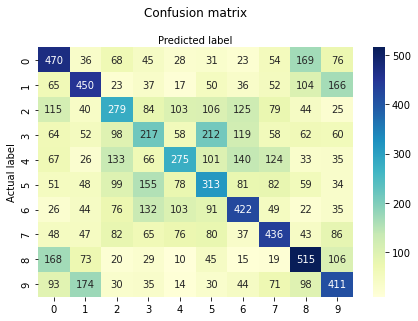

In [ ]:
# import required modules
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
cf_matrix = confusion_matrix(y_test, y_preds_final)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Part 3. Support Vector Machine (SVM) Classification (4 Marks)

In Part 3. you will use Scikit-learn to perform classification, again on the Cifar10 dataset. You can use the built in SVM library for classification. As with logistic regression, SVM is designed for binary classification. However, in this case Scikit-learn will handle the OvR models behind the scenes.

Your task is to compare different modes of the SVM and determine the best performer. 

Create an SVM baseline using the <code>LinearSVC()</code> function. Make sure to use the primal solution and use "ovr" for multiclass Calculate the accuracy score for comparison.

Next you will explore the effect of the cost parameter on the accuracy.
    <ul>
    <li>Run the classification with a range of C values For example: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]</li>
    <li>Plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>

Add a regularization term.
    <ul>
    <li>Rerun the above experiment, but this time use L1 regularization.</li>
    <li>Again, plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>

For the final experiment you will use the ```SVC()``` function to run the classifer with a kernel.
    <ul>
    <li>Use a radial basis function when training a new model</li>
    <li>Find the optimal combination of values for the cost and gamma parameters. Use the following values in your loop:<br/>
        <div style="margin-left:40px"><code>
        for cost in [0.01, 0.1, 1, 10, 100]:<br/>
        &emsp;for gamma in [0.01, 0.1, 1, 10, 100]:
        </code></div>
    </li>
    <li>Again, plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>


Choose the model with the highest accuracy and plot the confusion matrix. In your discussion explain the results of your experiments and the reason for increased performance from the baseline (if any). Comment on the effect of the cost-paramenter and the L1 penalty on accuracy as well as any overfitting you observed. Discuss the confusion matrix of the model accuracy and provide some reasons for high-values found off the main diagonal.

### Bonus Mark
Instead of using raw pixel values compute an alternate feature representation for your dataset and re-run train the model. Compare the accuracy of the model using the new feature representation with the model trained with pixel values.

In [ ]:
# Run your SVM experiments here.

#**SVM**

##**SVM baseline**

In [ ]:
svc_ovr =LinearSVC(multi_class='ovr',dual = False)
svc_ovr.fit(X_train, y_train)
y_predSVM = svc_ovr.predict(X_test)
print("the acc for SVMlinear : ",accuracy_score(y_test, y_predSVM))

C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


the acc for SVMlinear :  0.3212


Text(0.5, 257.44, 'Predicted label')

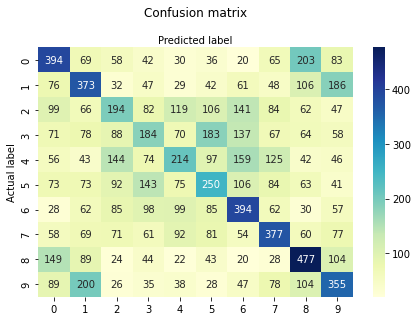

In [ ]:
# import required modules
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
cf_matrix = confusion_matrix(y_test, y_predSVM)
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

##**The classification with a range of C values**

In [ ]:
C_range  = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]
ts_scores = []
for C in C_range:
  svc_ovrC =LinearSVC(multi_class='ovr')
  svc_ovrC.fit(X_train, y_train)
  y_pred_with_C = svc_ovrC.predict(X_test)
  scores = (metrics.accuracy_score(y_test, y_pred_with_C))
  ts_scores.append(scores)
  print(f'the cost : {C}, accuracy: {scores:.3f} %')
print("The list of the accuracy : ",ts_scores) 

C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 0.0001, accuracy: 0.171 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 0.001, accuracy: 0.248 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 0.01, accuracy: 0.136 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 0.1, accuracy: 0.226 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 1, accuracy: 0.223 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 10, accuracy: 0.224 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 100, accuracy: 0.160 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 1000, accuracy: 0.211 %
The list of the accuracy :  [0.1713, 0.2479, 0.1355, 0.2255, 0.2234, 0.2242, 0.1598, 0.2114]


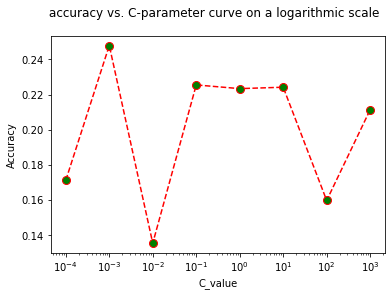

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(C_range, ts_scores,marker="o",markerfacecolor="green",
         linestyle="dashed",color="red",markersize=8)
ax.set_xlabel('C_value')
ax.set_ylabel('Accuracy')
fig.suptitle(" accuracy vs. C-parameter curve on a logarithmic scale")
plt.show()

##**Add L1 Regularization**

In [ ]:
C_range  = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]
ts_scores2 = []
for C in C_range:
  svc_ovrCL =LinearSVC(multi_class='ovr',penalty='l1',dual=False)
  svc_ovrCL.fit(X_train, y_train)
  y_pred_with_penalty = svc_ovrCL.predict(X_test)
  scores = (metrics.accuracy_score(y_test, y_pred_with_penalty))
  ts_scores2.append(scores)
  print(f'the cost : {C}, accuracy: {scores:.3f} %')
print("The list of the accuracy : ",ts_scores2) 

C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 0.0001, accuracy: 0.387 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 0.001, accuracy: 0.386 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 0.01, accuracy: 0.386 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 0.1, accuracy: 0.387 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 1, accuracy: 0.387 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 10, accuracy: 0.387 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 100, accuracy: 0.386 %


C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Eman Abood\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


the cost : 1000, accuracy: 0.387 %
The list of the accuracy :  [0.3874, 0.386, 0.3863, 0.3869, 0.3868, 0.3868, 0.3863, 0.3868]


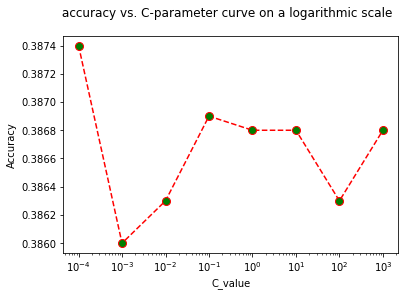

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(C_range, ts_scores2,marker="o",markerfacecolor="green",
         linestyle="dashed",color="red",markersize=8)
ax.set_xlabel('C_value')
ax.set_ylabel('Accuracy') 
fig.suptitle(" accuracy vs. C-parameter curve on a logarithmic scale")
plt.show()

##**SVM with kernal 'rbf'**

In [6]:
ts_scores3 = []
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_train, y_train)
y_pred_rbf = svc_rbf.predict(X_test)
scores = (metrics.accuracy_score(y_test, y_pred_rbf))
ts_scores3.append(scores)
print(ts_scores3) 

[0.5199]


In [ ]:
from sklearn.metrics import accuracy_score
C_range = [0.01, 0.1, 1, 10, 100]
gamma_range = [0.01, 0.1, 1, 10, 100]
ts_scores4=[]
final_accuracy=[]
alists=[]
for C in C_range:
    for gamma in gamma_range:
        clfsvm = SVC(C=C,kernel='rbf', gamma=gamma)
        clfsvm.fit(X_train, y_train)
        y_pred_svm = clfsvm.predict(X_test)
        scores = accuracy_score(y_test, y_pred_svm)
        ts_scores4.append(scores)
        print (C,"",gamma,"",scores)
        print(f'range: {C}, gamma: {gamma}, accuracy: {scores:.3f} %')
    print("The list of the accuracy for one num of cost : ",ts_scores4) 
    alists.append(ts_scores4)
    print("The list of the accuracy : ",alists) 
    final_accuracy.append(np.max(ts_scores4)) 
    ts_scores4=[]
print ("The final accuracy : ",final_accuracy)

C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.01  0.01  0.292
range: 0.01, gamma: 0.01, accuracy: 0.292 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.01  0.1  0.1
range: 0.01, gamma: 0.1, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.01  1  0.1
range: 0.01, gamma: 1, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.01  10  0.1
range: 0.01, gamma: 10, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.01  100  0.1
range: 0.01, gamma: 100, accuracy: 0.100 %
The list of the accuracy for one num of cost :  [0.292, 0.1, 0.1, 0.1, 0.1]
The list of the accuracy :  [[0.292, 0.1, 0.1, 0.1, 0.1]]


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1  0.01  0.4246
range: 0.1, gamma: 0.01, accuracy: 0.425 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1  0.1  0.1
range: 0.1, gamma: 0.1, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1  1  0.1
range: 0.1, gamma: 1, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1  10  0.1
range: 0.1, gamma: 10, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1  100  0.1
range: 0.1, gamma: 100, accuracy: 0.100 %
The list of the accuracy for one num of cost :  [0.4246, 0.1, 0.1, 0.1, 0.1]
The list of the accuracy :  [[0.292, 0.1, 0.1, 0.1, 0.1], [0.4246, 0.1, 0.1, 0.1, 0.1]]


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1  0.01  0.5272
range: 1, gamma: 0.01, accuracy: 0.527 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1  0.1  0.1759
range: 1, gamma: 0.1, accuracy: 0.176 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1  1  0.1
range: 1, gamma: 1, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1  10  0.1
range: 1, gamma: 10, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1  100  0.1
range: 1, gamma: 100, accuracy: 0.100 %
The list of the accuracy for one num of cost :  [0.5272, 0.1759, 0.1, 0.1, 0.1]
The list of the accuracy :  [[0.292, 0.1, 0.1, 0.1, 0.1], [0.4246, 0.1, 0.1, 0.1, 0.1], [0.5272, 0.1759, 0.1, 0.1, 0.1]]


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10  0.01  0.5372
range: 10, gamma: 0.01, accuracy: 0.537 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10  0.1  0.191
range: 10, gamma: 0.1, accuracy: 0.191 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10  1  0.1
range: 10, gamma: 1, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10  10  0.1
range: 10, gamma: 10, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10  100  0.1
range: 10, gamma: 100, accuracy: 0.100 %
The list of the accuracy for one num of cost :  [0.5372, 0.191, 0.1, 0.1, 0.1]
The list of the accuracy :  [[0.292, 0.1, 0.1, 0.1, 0.1], [0.4246, 0.1, 0.1, 0.1, 0.1], [0.5272, 0.1759, 0.1, 0.1, 0.1], [0.5372, 0.191, 0.1, 0.1, 0.1]]


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100  0.01  0.5354
range: 100, gamma: 0.01, accuracy: 0.535 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100  0.1  0.191
range: 100, gamma: 0.1, accuracy: 0.191 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100  1  0.1
range: 100, gamma: 1, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100  10  0.1
range: 100, gamma: 10, accuracy: 0.100 %


C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100  100  0.1
range: 100, gamma: 100, accuracy: 0.100 %
The list of the accuracy for one num of cost :  [0.5354, 0.191, 0.1, 0.1, 0.1]
The list of the accuracy :  [[0.292, 0.1, 0.1, 0.1, 0.1], [0.4246, 0.1, 0.1, 0.1, 0.1], [0.5272, 0.1759, 0.1, 0.1, 0.1], [0.5372, 0.191, 0.1, 0.1, 0.1], [0.5354, 0.191, 0.1, 0.1, 0.1]]
The final accuracy :  [0.292, 0.4246, 0.5272, 0.5372, 0.5354]


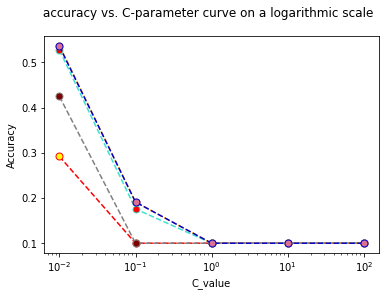

In [ ]:
C_range = [0.01, 0.1, 1, 10, 100]
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(C_range, alists[0],marker="o",markerfacecolor="red",
         linestyle="dotted",color="turquoise",markersize=9)
ax.plot(C_range, alists[1],marker="o",markerfacecolor="maroon",
         linestyle="dotted",color="Cyan",markersize=9)
ax.plot(C_range, alists[2],marker="o",markerfacecolor="navy",
         linestyle="dotted",color="orange",markersize=9)
ax.plot(C_range, alists[3],marker="o",markerfacecolor="yellow",
         linestyle="dotted",color="red",markersize=9)
ax.plot(C_range, alists[4],marker="o",markerfacecolor="palevioletred",
         linestyle="dotted",color="mediumblue",markersize=9)
ax.set_xlabel('C_value')
ax.set_ylabel('Accuracy') 
fig.suptitle(" accuracy vs. C-parameter curve on a logarithmic scale") 
plt.show()

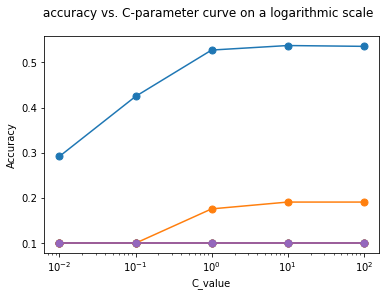

In [ ]:
C_range = [0.01, 0.1, 1, 10, 100]
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(C_range, alists,marker="o",markersize=9)
ax.set_xlabel('C_value')
ax.set_ylabel('Accuracy')  
fig.suptitle(" accuracy vs. C-parameter curve on a logarithmic scale")  
plt.show()

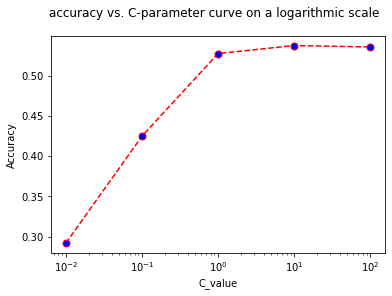

In [ ]:
C_range = [0.01, 0.1, 1, 10, 100]
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(C_range, final_accuracy,marker="o",markerfacecolor="blue",
         linestyle="dashed",color="red",markersize=9)
ax.set_xlabel('C_value')
ax.set_ylabel('Accuracy')  
fig.suptitle(" accuracy vs. C-parameter curve on a logarithmic scale")  
plt.show()

##**The highest SVM model with kernal 'rbf' (c=10,gamma=0.01)**

C:\Users\lap5\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy is 0.5372


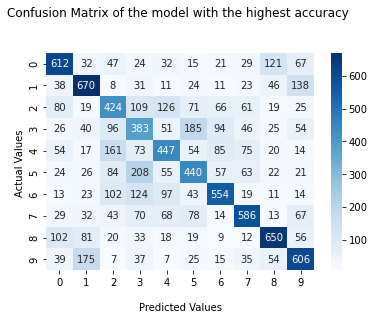

In [ ]:
highestmodel = SVC(kernel='rbf',C=10,gamma=0.01)
highestmodel.fit(X_train, y_train)
y_predHM = highestmodel.predict(X_test)
scores = (metrics.accuracy_score(y_test, y_predHM))
print ("Accuracy is",scores)
cf_matrix_svmhm = confusion_matrix(y_test, y_predHM)
ax = sns.heatmap(cf_matrix_svmhm, annot=True, cmap='Blues',fmt='d')
ax.set_title('Confusion Matrix of the model with the highest accuracy \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

##**discussion of SVM results**

#####I saw from the results that in SVM, a high Gamma value leads to increased accuracy but skewed results, and vice versa. The model with the highest accuracy that we used the SVC function, "rbf" kernel, gamma, and cost had an accuracy of 53.72%

#####Therefore, how much data an SVM can bend with is determined by utilizing the cost parameter. While accurately classification more points is desirable at a higher cost (giving greater cost (C) values offers me higher accuracy),The cost of misclassification is another name for it, and when there are many features, L1 regularisation is the best choice because it yields sparse solutions. However, we improve practically by removing features with zero slopes.

#####The model accurately assigned an image to its currently prevalent is the true positive prediction. For example, out of the 1017 images in our testing set with class 0 , the model detects 612 of them as correct classifications and 405 as incorrect classifications.

## Part 4. Write a Conclusion (1 Mark)


###**KNN** 
The accurecy with best k and best metric is : 0.2108 , the KNN is not good model with images and discovered that the accuracy of the data is determined by its quality. With a large amount of data, the fitting and prediction stage may take a long time, be sensitive to the size of the data, and be sensitive to features that aren't significant. first, I choose euclidian metric because it helps to have more than one class with good performance, when I used manhattan, it was a good performance in one class. second, when K=11 was the best performance of any other class. it gives an accuracy equal 21.08% .

The model accurately assigned an image to its currently prevalent is the true positive prediction. For example, out of the 4621 images in our testing set with class 0 , the model detects 704 of them as correct classifications and 3917 as incorrect classifications.
###**Logistic Regression**
The accuracy is :0.3788 , it is better than KNN. first, logistic regression can be used to predict a different variable which can assume more than 2 values or classes ,so it works well with our data.
The model accurately assigned an image to its currently prevalent is the true positive prediction. For example, out of the 1167 images in our testing set with class 0 , the model detects 470 of them as correct classifications and 697 as incorrect classifications.
###**SVM**
1)BY using "Linear SVC " we foud that the accuray is lower than the accuracy of LR,the accuracy for SVMlinear :  0.3212

2)When adding L1 Regularization , we noticed that the accuracy is improved than using ovr only , the accuracy with L1 Regularization :The list of the accuracy [0.3874, 0.386, 0.3863, 0.3869, 0.3868, 0.3868, 0.3863, 0.3868]

3)When using "SVC" kernal "rbf" , Cost ,and Gamma the accuracies are improved The list of the accuracy : [[0.292, 0.1, 0.1, 0.1, 0.1], [0.4246, 0.1, 0.1, 0.1, 0.1], [0.5272, 0.1759, 0.1, 0.1, 0.1], [0.5372, 0.191, 0.1, 0.1, 0.1], [0.5354, 0.191, 0.1, 0.1, 0.1]], (the best accuracy when gamma = 0.01, C= 10 and also when gamma = 0.01, c=100 ) with accuracy of 0.5372% 
Therefore, how much data an SVM can bend with is determined by utilizing the cost parameter. While accurately classification more points is desirable at a higher cost (giving greater cost (C) values offers me higher accuracy),The cost of misclassification is another name for it, and when there are many features, L1 regularisation is the best choice because it yields sparse solutions. However, we improve practically by removing features with zero slopes.
The model accurately assigned an image to its currently prevalent is the true positive prediction. For example, out of the 1017 images in our testing set with class 0 , the model detects 612 of them as correct classifications and 405 as incorrect classifications.
#####**finally, SVM with kernal rbf is the best model among all the models we used.**

<!-- Write your conclusion here -->